In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

In [2]:
df_baby = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Baby_5.json', lines=True )
df_electronic = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Electronics_5.json', lines=True )
df_healthAnnPersonalCare = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Health_and_Personal_Care_5.json', lines=True )
df_sportsAndOutdoors = pd.read_json('/content/drive/MyDrive/COLAB/NLP/Practica/datasets/reviews_Sports_and_Outdoors_5.json', lines=True )

In [3]:
dfAll = [df_baby, df_electronic, df_healthAnnPersonalCare, df_sportsAndOutdoors]
df = pd.concat(dfAll)

In [4]:
df = df.iloc[:200000,]
df.head(5)

reviewerID        asin  ... unixReviewTime   reviewTime
0  A1HK2FQW6KXQB2  097293751X  ...     1373932800  07 16, 2013
1  A19K65VY14D13R  097293751X  ...     1372464000  06 29, 2013
2  A2LL1TGG90977E  097293751X  ...     1395187200  03 19, 2014
3   A5G19RYX8599E  097293751X  ...     1376697600  08 17, 2013
4   A2496A4EWMLQ7  097293751X  ...     1396310400   04 1, 2014

[5 rows x 9 columns]

In [5]:
df = df[['reviewText', 'overall']]
df.dropna(inplace=True)

In [6]:
df.head()

reviewText  overall
0  Perfect for new parents. We were able to keep ...        5
1  This book is such a life saver.  It has been s...        5
2  Helps me know exactly how my babies day has go...        5
3  I bought this a few times for my older son and...        5
4  I wanted an alternative to printing out daily ...        4

In [7]:
# Tenemos puntuaciones de 0 a 5 estrellas
# Decido que 1,2 sean reviews negativas y 3,4,5 positivos.

def label_sentiment(row):
    if int(row['overall']) <= 2:
        return 'neg'
    else:
        return 'pos'

In [8]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [9]:
df.head()

reviewText  overall sentiment_label
0  Perfect for new parents. We were able to keep ...        5             pos
1  This book is such a life saver.  It has been s...        5             pos
2  Helps me know exactly how my babies day has go...        5             pos
3  I bought this a few times for my older son and...        5             pos
4  I wanted an alternative to printing out daily ...        4             pos

In [10]:
# Train y Test
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [11]:
X_train.iloc[:10]

21743     I love the Waldorf-type dolls and own more tha...
124554    This is a great carrier if you have back probl...
10351     So much bigger than we expected! Perfect for a...
135164    This item is not made for an early teether of ...
49969     My son loves using this.  It works well and is...
47120     The 2-Phase Expression technology is amazing a...
4249      I like Gerber products. My son uses Gerber bot...
59266     My baby loves this little dog.  She likes bein...
32546     My daughter has loved this jumparoo! She's use...
74977     We have been using this product since, my now ...
Name: reviewText, dtype: object

In [12]:
y_train.iloc[:10]

21743     pos
124554    pos
10351     pos
135164    pos
49969     pos
47120     pos
4249      pos
59266     pos
32546     pos
74977     pos
Name: sentiment_label, dtype: object

In [13]:
# Extracción de features
# convierto a minusculas
# Elimino acentos y simbolos especiales
# Trabajare con 3500 palabras máximas

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=3500,
    strip_accents='unicode',
    stop_words = 'english',
    ngram_range=(2, 4)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=3500,
                min_df=5, ngram_range=(2, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
print(list(cv.vocabulary_.items())[:20])

[('just don', 1509), ('don want', 898), ('baby able', 128), ('able use', 74), ('period time', 2251), ('time great', 3019), ('make sure', 1936), ('safe baby', 2600), ('mo old', 1988), ('day long', 687), ('living room', 1777), ('baby needs', 206), ('lots room', 1845), ('time baby', 3006), ('maybe just', 1963), ('son loves', 2809), ('easy use', 980), ('like said', 1709), ('price great', 2344), ('great product', 1297)]


In [15]:
# TF-IDF scores del training set y test set
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [16]:
# Palabras con el TF-IDF en alguna review
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 57356
Sentiment: pos
Review: My son was very oral when teething (still is) and really enjoyed chewing on the banana.  We didn't really use it as much of a toothbrush, rather as a teether.  It held up well.


In [17]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 57356:
                   tfidf
really enjoyed  0.636247
really use      0.561867
didn really     0.528673

Top 10 words with lowest TF_IDF in the review 57356:
                   tfidf
really enjoyed  0.636247
really use      0.561867
didn really     0.528673


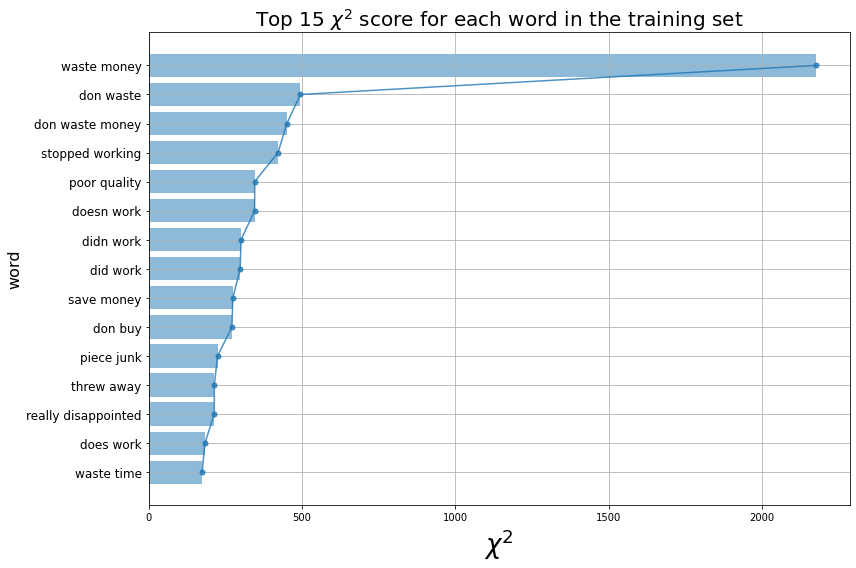

In [18]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [19]:
# Entrenamiento
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.89374
Accuracy for C=0.05: 0.89622
Accuracy for C=0.25: 0.90158
Accuracy for C=0.5: 0.90328
Accuracy for C=1: 0.90388
Accuracy for C=10: 0.90362
Accuracy for C=100: 0.90324


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=1000: 0.90332


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for C=10000: 0.90328


In [20]:
print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

Accuracy for C=10000: 0.90328


In [21]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 1244  4088]
 [  748 43920]]

Classification report:
              precision    recall  f1-score   support

         neg       0.62      0.23      0.34      5332
         pos       0.91      0.98      0.95     44668

    accuracy                           0.90     50000
   macro avg       0.77      0.61      0.64     50000
weighted avg       0.88      0.90      0.88     50000

Accuracy score:0.90328


In [22]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 1244  4088]
 [  748 43920]]

Classification report:
              precision    recall  f1-score   support

         neg       0.62      0.23      0.34      5332
         pos       0.91      0.98      0.95     44668

    accuracy                           0.90     50000
   macro avg       0.77      0.61      0.64     50000
weighted avg       0.88      0.90      0.88     50000

Accuracy score:0.90328


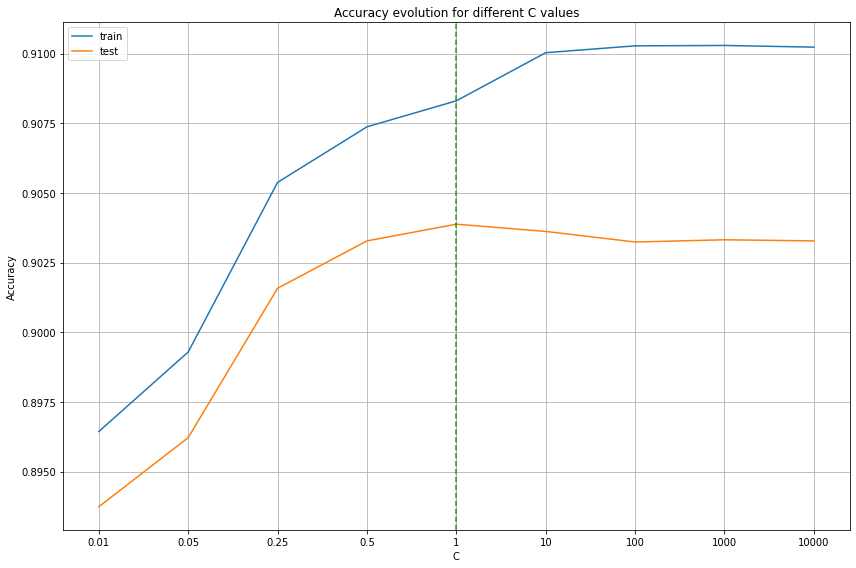

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [24]:
# Predict
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [25]:
for i in random.sample(range(0, len(df)), 20):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 162446
Actual sentiment: pos
Prediction: ['pos']

Review no. 189408
Actual sentiment: pos
Prediction: ['pos']

Review no. 83859
Actual sentiment: neg
Prediction: ['pos']

Review no. 41910
Actual sentiment: pos
Prediction: ['pos']

Review no. 160716
Actual sentiment: pos
Prediction: ['pos']

Review no. 838
Actual sentiment: pos
Prediction: ['pos']

Review no. 123288
Actual sentiment: pos
Prediction: ['neg']

Review no. 51636
Actual sentiment: pos
Prediction: ['pos']

Review no. 50023
Actual sentiment: pos
Prediction: ['pos']

Review no. 194099
Actual sentiment: pos
Prediction: ['pos']

Review no. 21742
Actual sentiment: pos
Prediction: ['pos']

Review no. 143517
Actual sentiment: pos
Prediction: ['pos']

Review no. 119670
Actual sentiment: pos
Prediction: ['pos']

Review no. 119441
Actual sentiment: neg
Prediction: ['neg']

Review no. 171456
Actual sentiment: pos
Prediction: ['pos']

Review no. 115853
Actual sentiment: pos
Prediction: ['pos']

Review no. 139856
Actual sentim